In [2]:
import torch
from torchvision import models, transforms, datasets

from pathlib import Path
import os
import random
from torchinfo import summary
from torch import nn
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from helper_functions import accuracy_fn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = "mps" if torch.backends.mps.is_available else "cpu"
device

'mps'

In [3]:
rootFolder = Path("data/GarbageClassification")
testFolder = rootFolder/"TEST"
trainFolder = rootFolder/"TRAIN"
validationFolder = rootFolder/"VALIDATION"

In [4]:
for path,folders,files in os.walk(rootFolder):
    print(f"In {path} there are {len(folders)} folders and {len(files)} images")

In data/GarbageClassification there are 3 folders and 1 images
In data/GarbageClassification/TEST there are 10 folders and 1 images
In data/GarbageClassification/TEST/paper there are 0 folders and 681 images
In data/GarbageClassification/TEST/clothes there are 0 folders and 1331 images
In data/GarbageClassification/TEST/metal there are 0 folders and 467 images
In data/GarbageClassification/TEST/cardboard there are 0 folders and 585 images
In data/GarbageClassification/TEST/trash there are 0 folders and 208 images
In data/GarbageClassification/TEST/glass there are 0 folders and 1024 images
In data/GarbageClassification/TEST/biological there are 0 folders and 246 images
In data/GarbageClassification/TEST/battery there are 0 folders and 236 images
In data/GarbageClassification/TEST/plastic there are 0 folders and 635 images
In data/GarbageClassification/TEST/shoes there are 0 folders and 494 images
In data/GarbageClassification/TRAIN there are 10 folders and 1 images
In data/GarbageClassi

In [5]:
allFiles = rootFolder.glob("*/*/*")

In [6]:
# Separating the files

import shutil

CLASSES = ['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

def TrainAndTestFolderSeperation(rootDir,classes,splitPerc=0.25):

    TRAIN_DIR = rootDir/"TRAIN"
    TEST_DIR = rootDir/"TEST"

    
    if(os.path.isdir(TRAIN_DIR)):
        print("TRUE")
    else:
        os.mkdir(TRAIN_DIR)

        for cls in classes:
            os.mkdir(TRAIN_DIR/cls)
        
        os.mkdir(TEST_DIR)

        for cls in classes:
            os.mkdir(TEST_DIR/cls)

    for cls in classes:

        CLASS_DIR = rootDir / cls
        allfiles = CLASS_DIR.glob("*")
        file_paths = [file_path for file_path in allfiles]
        

        for j in range(int(len(file_paths) * splitPerc)):
            RANDOM_NUMBER = random.randint(0,len(file_paths)-1)

            try:
                shutil.move(CLASS_DIR/file_paths[RANDOM_NUMBER].name, TEST_DIR/cls/file_paths[RANDOM_NUMBER].name)
                file_paths.remove(file_paths[RANDOM_NUMBER])
            except:
                continue

        for j in file_paths:
            
            try:
                shutil.move(CLASS_DIR/j.name, TRAIN_DIR/cls/j.name)
            except:
                pass
            
        os.removedirs(CLASS_DIR)

#TrainAndTestFolderSeperation(rootFolder,CLASSES)


In [7]:
# define the model

weights = models.EfficientNet_B0_Weights.DEFAULT 
model = models.efficientnet_b0(weights=weights).to(device)


output_shape = len(CLASSES)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape,
                    bias=True)).to(device)
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
# Transforms on Images for efficientnet

auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
# Getting Data Loaders
from PIL import Image
TrainDataSet = datasets.ImageFolder(root=trainFolder,transform=auto_transforms)
TestDataSet = datasets.ImageFolder(root=testFolder,transform=auto_transforms)
CLASSES = TrainDataSet.classes



class MyDataset(Dataset):
    def __init__(self, image_dir, transform):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path).convert("RGB")
        image = transforms.ToTensor()(image)
        image = self.transform(image)
        return image

ValidationDataSet = MyDataset(validationFolder, auto_transforms)


BATCH_SIZE = 32


TRAIN_DATA_LOADER = torch.utils.data.DataLoader(

    TrainDataSet,
    batch_size=BATCH_SIZE,
    shuffle=True,

)

TEST_DATA_LOADER = torch.utils.data.DataLoader(

    TestDataSet,
    batch_size=BATCH_SIZE,
    shuffle=True,

)


VALIDATION_DATA_LOADER = DataLoader(
    ValidationDataSet,
    batch_size=1
)







In [10]:
# freezing the model for tf learning

for param in model.features.parameters():
    param.requires_grad = False

In [11]:
# Updating the classifier layer


In [12]:
summary(model, 
        input_size=(20, 3, 224, 224), 
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [20, 3, 224, 224]    [20, 10]             --                   Partial
├─Sequential (features)                                      [20, 3, 224, 224]    [20, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [20, 3, 224, 224]    [20, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [20, 3, 224, 224]    [20, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [20, 32, 112, 112]   [20, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [20, 32, 112, 112]   [20, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [20, 32, 112, 112]   [20, 

In [12]:
# loss and optimiser

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [13]:



from timeit import default_timer as timer 
start_time = timer()

epochs = 5

accuracy_list = []


model.to(device)
for epoch in range(epochs):

    print(f"\n--------- epoch {epoch}-----------")

    train_loss = 0

    for Images, Label in tqdm(TRAIN_DATA_LOADER, "TRAIN IMAGES"):

        Images,Label = Images.to(device),Label.to(device)

        
        model.train()

        preds = model(Images)
        
        loss = loss_fn(preds,Label)
        train_loss += loss

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()


    train_loss /= len(TRAIN_DATA_LOADER) 

    print(f"The traing loss was {train_loss}")



end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


--------- epoch 0-----------


TRAIN IMAGES:   0%|          | 0/555 [00:00<?, ?it/s]

The traing loss was 0.6504240036010742

--------- epoch 1-----------


TRAIN IMAGES:   0%|          | 0/555 [00:00<?, ?it/s]

The traing loss was 0.5741108655929565

--------- epoch 2-----------


TRAIN IMAGES:   0%|          | 0/555 [00:00<?, ?it/s]

The traing loss was 0.614438533782959

--------- epoch 3-----------


TRAIN IMAGES:   0%|          | 0/555 [00:00<?, ?it/s]

The traing loss was 0.6072158813476562

--------- epoch 4-----------


TRAIN IMAGES:   0%|          | 0/555 [00:00<?, ?it/s]

The traing loss was 0.637441098690033
[INFO] Total training time: 618.228 seconds


----------------- Evaluating Model ---------------


TEST IMAGES:   0%|          | 0/185 [00:00<?, ?it/s]

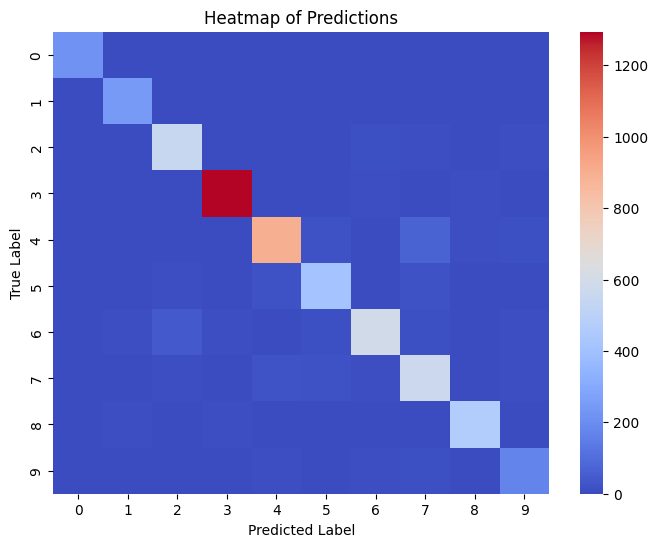

The test accureacy is 91.29445234708393 


In [14]:

import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix

def draw_heat_map(predictions, labels, colormap='viridis', title='Heatmap of Predictions',
                 figsize=(8, 6), annot=True, plot_type='confusion_matrix',
                 normalize=None, vmin=None, vmax=None, show=True):
    

    if plot_type == 'confusion_matrix':
        cm = confusion_matrix(labels, predictions, normalize=normalize)
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(cm, annot=annot, fmt='g', cmap=colormap, ax=ax,
                    vmin=vmin, vmax=vmax)
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        ax.set_title(title)
    elif plot_type == 'classification_report':
        report = classification_report(labels, predictions)
        fig, ax = plt.subplots(figsize=figsize)
        ax.text(0.1, 0.1, report, fontsize=8, bbox=dict(facecolor='white'))
        ax.axis('off')
        ax.set_title(title)
    else:
        raise ValueError("Invalid plot_type. Choose from 'confusion_matrix' or 'classification_report'.")

    if show:
        plt.show()
    return fig


final_preds = torch.empty(0)
final_labs = torch.empty(0)

print(f"----------------- Evaluating Model ---------------")
    
model.eval()

test_accuracy = 0
model.to(device)





with torch.inference_mode():

    

    for Image, Label in tqdm(TEST_DATA_LOADER, "TEST IMAGES"):

        Image, Label = Image.to(device), Label.to(device)

        preds = model(Image)
        preds = preds.argmax(dim=1)

        final_preds = torch.hstack([final_preds, preds.cpu()])
        final_labs = torch.hstack([final_labs, Label.cpu()])
        
        
        accuracy = accuracy_fn(Label,preds)
        test_accuracy += accuracy

        

    test_accuracy /= len(TEST_DATA_LOADER)
    draw_heat_map(final_preds.cpu(), final_labs.cpu(), colormap='coolwarm', annot=False)
    

print(f"The test accureacy is {test_accuracy} ")


In [15]:
CLASSES

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [16]:
path = Path("models")
name = "SweepNet2.pth"

fullPath = path / name


torch.save(model.state_dict(),fullPath)
print("model saved ..")

model saved ..


In [20]:
path = Path("models")
name = "SweepNet2.pth"

fullPath = path / name

weights_1 = models.EfficientNet_B0_Weights.DEFAULT 
model_1 = models.efficientnet_b0(weights=weights_1)


output_shape_1 = len(CLASSES)

model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape_1,
                    bias=True))
model_1.load_state_dict(torch.load(fullPath))

<All keys matched successfully>

In [18]:

"""
import cv2


model_1.eval()

man_transforms = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

cam = cv2.VideoCapture(0)
k = 0

to_pil = transforms.ToPILImage()

with torch.no_grad():
    while True:
        _, frame = cam.read()
        cv2.imshow("i", frame)
        
        if k % 10 == 0:
            frame_pil = to_pil(frame)
            frame_tensor = man_transforms(frame_pil)
            frame_tensor = frame_tensor.unsqueeze(0)  # Add batch dimension
            pred = model_1(frame_tensor)
            pred_class = pred.argmax(dim=1)
            print(CLASSES[pred_class.item()])
    
        k += 1
"""

x =2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

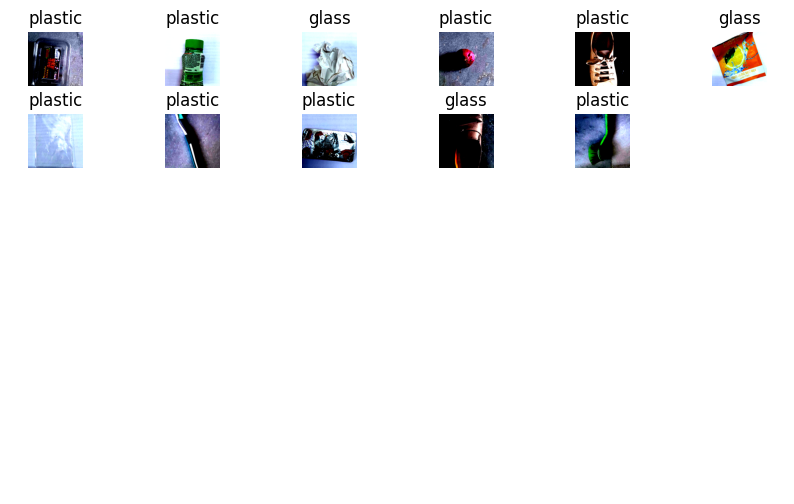

In [22]:
fig, axs = plt.subplots(6, 6, figsize=(10, 6))
fig.subplots_adjust(wspace=0.5, hspace=0.5) 

for ax in axs.flat:
    ax.axis('off')


axs = axs.flatten()



with torch.inference_mode():
    for i,image in enumerate(VALIDATION_DATA_LOADER):
        #print(image[0].unsqueeze(dim=0).shape)
        pred = model_1(image[0].unsqueeze(dim=0))
        pred_class = pred.argmax(dim=1)
        prediction = CLASSES[pred_class.item()]

        axs[i].imshow(image[0].permute(1,2,0).numpy())
        axs[i].set_title(prediction)

    plt.show()
    